In [1]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
import sklearn.metrics
import sklearn.neighbors
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
import tensorflow as tf
import numpy as np
import time
import h5py
import scipy.io as sio

import pandas as pd
import re

c:\Users\bxz19\anaconda3\envs\tf1_env\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load the data

In [14]:
# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('GCNN_paper_adaptation')
data_dir = working_dir + 'Thesis/data/PROTECTED_DATA/BGI_Expression_Data/'


## Load the datasets
# Transcriptomics Data 
transcriptomics_TumorOnly_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM_TumorOnly.csv'
transcriptomics_dataset = pd.read_csv(transcriptomics_TumorOnly_dir, index_col=0)

# Classification Tags
labels_classification_dir = data_dir + 'Gender_for_TumorSamples_Classification.csv'
labels = pd.read_csv(labels_classification_dir, index_col=0)


# Figures Saving output dir


# Convert The directory to the name of the column
trait_used_as_label = labels_classification_dir.replace(data_dir, '').replace('_for_TumorSamples_Classification.csv', '')
trait_used_as_label = re.sub(r'(?<=\w)([A-Z])', r' \1', trait_used_as_label) # Add spaces before the capital letters for formatting


# Convert labels to categorical values
class_values = labels[trait_used_as_label].astype('category').cat.codes
labels['label'] = class_values

# """
## Make a subset to save RAM
subset_dataset_size = 400
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 
# """

### Preprocessing as per in the paper

In [ ]:
## Paper preprocessing (Super Agressive)

###Important to notice than in the paper, they work with log2(FPKM + 1) and we have TPM
# Applying log transformation to TPM data
transcriptomics_log_transformed = np.log2(transcriptomics_dataset + 1)


# thresholds as per the paper
mean_threshold = 0.5
std_dev_threshold = 0.8

# Kepp only genes with mean expression>0.5 and standard deviation>0.8
genes_mean_expression = transcriptomics_log_transformed.mean(axis=0)
genes_std_deviation = transcriptomics_log_transformed.std(axis=0)
transcriptomics_clean = transcriptomics_log_transformed.loc[:, (genes_mean_expression > mean_threshold) & (genes_std_deviation > std_dev_threshold)]

# Print the number of genes removed
num_genes_removed = transcriptomics_dataset.shape[1] - transcriptomics_clean.shape[1]
print("Preprocessing removed", str(num_genes_removed), "genes")
print("We have", str(transcriptomics_clean.shape[1]), "genes left")


# Normalize gene expression between 0 and 1
transcriptomics_normalized = (transcriptomics_clean - transcriptomics_clean.min()) / (transcriptomics_clean.max() - transcriptomics_clean.min())


Preprocessing removed 169 genes
We have 31 genes left


In [15]:
# The preprocessing used in all other methods, to test its effect in this method


expression_th = 1.5

# Filter out genes with low expression across all samples
transcriptomics_normalized = transcriptomics_dataset.loc[:, (transcriptomics_dataset > expression_th).any(axis=0)].copy()

# Apply log2 transformation to all values except for the first column (gene identifiers)
transcriptomics_normalized.iloc[:, 1:] = np.log2(transcriptomics_normalized.iloc[:, 1:] + 1)

# Data Standardization (Z-score normalization)
transcriptomics_normalized.iloc[:, 1:] = transcriptomics_normalized.iloc[:, 1:].apply(scipy.stats.zscore, axis=0)


# Print the number of genes removed
num_genes_removed = transcriptomics_dataset.shape[1] - transcriptomics_normalized.shape[1]
print("Preprocessing removed", str(num_genes_removed), "genes")
print("We have", str(transcriptomics_normalized.shape[1]), "genes left")

Preprocessing removed 22 genes
We have 378 genes left


### Build the binary Adjacency matrix as per the paper

In [16]:
## Build our own Adjacency matrix as per in the paper.

# Calculate Spearman Correlation and p-values
transcriptomics_np = transcriptomics_normalized.values
correlations, pvalues = scipy.stats.spearmanr(transcriptomics_np)

# Construct the Adjacency Matrix
adjacency_matrix_np = (correlations > 0.6) & (pvalues < 0.05)
adjacency_matrix_np = adjacency_matrix_np.astype(int)

# In the paper, they remove self-links
np.fill_diagonal(adjacency_matrix_np, 0)

# Remove Isolated Genes - does not correlate with any other gene
is_not_isolated = adjacency_matrix_np.sum(axis=1) > 0
filtered_adjacency_matrix_np = adjacency_matrix_np[is_not_isolated, :][:, is_not_isolated]

# Same data with different formatting
transcriptomics_normalized_Adj = transcriptomics_normalized.loc[:, is_not_isolated]


print(str(transcriptomics_normalized.shape[1]-filtered_adjacency_matrix_np.shape[0]), 'genes were removed as Isolated Genes')
print("We have", str(filtered_adjacency_matrix_np.shape[0]), "genes left")


247 genes were removed as Isolated Genes
We have 131 genes left


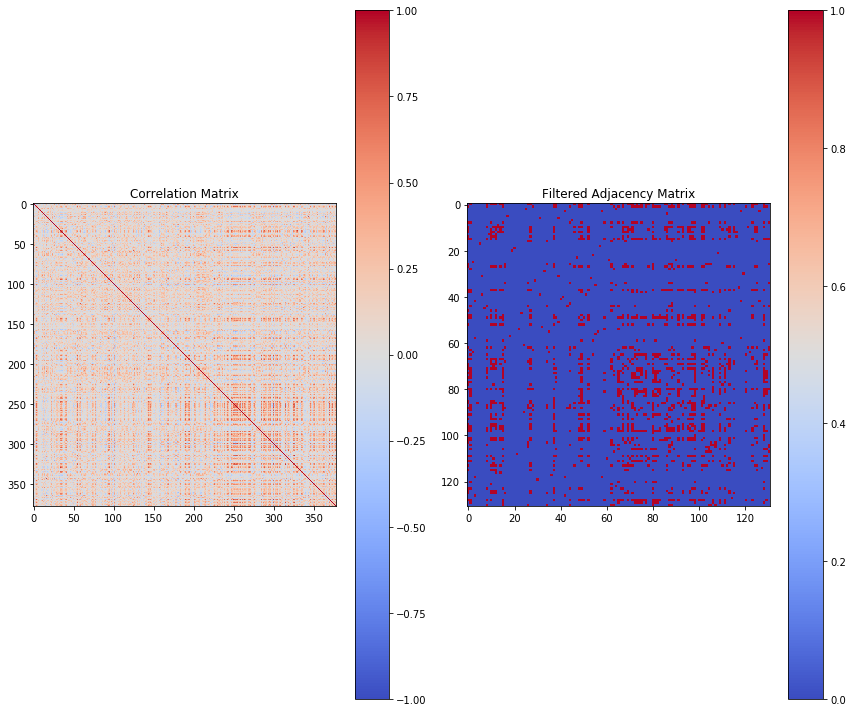

In [17]:
# Plot the heatmaps using matplotlib
plt.figure(figsize=(12, 10))

# Correlation Matrix Heatmap
plt.subplot(1, 2, 1)
plt.imshow(correlations, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')

# Filtered Adjacency Matrix Heatmap
plt.subplot(1, 2, 2)
plt.imshow(filtered_adjacency_matrix_np, cmap='coolwarm')
plt.colorbar()
plt.title('Filtered Adjacency Matrix')

plt.tight_layout()
plt.show()

Save the genes selected for the analysis, for further analysis

In [ ]:
selected_genes = transcriptomics_normalized_Adj.columns
genes_left_df = pd.DataFrame(selected_genes, columns=['Gene Name'])

# Save the gene names to a CSV file with one gene name per line
genes_left_df.to_csv('selected_genes.csv', index=False)

### Graph Coarsening

In [ ]:
# Transform into the weird formatting
connections_indices = np.where(filtered_adjacency_matrix_np == 1)
row = connections_indices[0].astype('float32')
col = connections_indices[1].astype('float32')
value = np.ones(len(col)).astype('float32')

In [ ]:
# Part of the original code
coarsening_levels = 1

A = scipy.sparse.coo_matrix((value, (row, col))) # Not enforcing shape
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True,renormalized=True) for A in graphs]


The Data for classification

In [ ]:
train_split = 0.8

# Shuffle samples
transcriptomics_normalized_shuffled = transcriptomics_normalized_Adj.sample(frac=1, random_state=42)

# Calculate the number of rows for each subset
total_rows = transcriptomics_normalized_shuffled.shape[0]
subset_1_rows = int(total_rows * train_split)

# Make train, test transcriptomics datasets
train_data = transcriptomics_normalized_shuffled.iloc[:subset_1_rows]
test_data = transcriptomics_normalized_shuffled.iloc[subset_1_rows:]

# Make train, test labels datasets
train_label = labels.loc[train_data.index]
test_label = labels.loc[test_data.index]

# Turn everything into matrix
train_data = train_data.values
test_data = test_data.values
train_label = train_label['label'].values.astype('float32')
test_label = test_label['label'].values.astype('float32')

# Make validation a copy of test, as in the paper
val_data = test_data.copy()
val_label = test_label.copy()

In [ ]:
# original code from this point on
Train_Data = coarsening.perm_data(train_data, perm[0])
Test_Data = coarsening.perm_data(test_data, perm[0])
Val_Data = coarsening.perm_data(val_data, perm[0])

In [ ]:
unique_label_count = labels['label'].nunique()   # number of classes

common = {}
common['dir_name']       = 'test/'
common['num_epochs']     = 100
common['batch_size']     = 50
common['decay_steps']    = 17.7 # * common['num_epochs'] since not used use as in momentum 
common['eval_frequency'] = 10 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'apool1'

model_perf = utils.model_perf()

common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = .001
common['decay_rate']     = 0.95
common['momentum']       = 0

common['F']              = [1]
common['K']              = [1]
common['p']              = [2]
common['M']              = [1024,unique_label_count]


name = 'Run1'
params = common.copy()
params['dir_name'] += name

params['filter'] = 'chebyshev2'
params['brelu'] = 'b1relu'

model_perf.test(models.cgcnn(L, **params), name, params, Train_Data, train_label, Val_Data, val_label, Test_Data, test_label)

model_perf.show()
